In [1]:
#--------------------------------------------------------------------------------
# Module 1: Loading pickled big boi data for GAN model
#--------------------------------------------------------------------------------
import os
import pandas as pd

# Ensure the directory "Processed data" exists before attempting to load the file
if os.path.exists("Processed data/data_encoded.csv"):
    data_encoded = pd.read_csv("Processed data/data_encoded.csv")
else:
    print("The CSV file does not exist in the specified directory.")


#import pickle
#import os

# Ensure the directory "Processed data" exists before attempting to load the file
#if os.path.exists("Processed data/data_encoded.csv"):
 #   with open("Processed data/data_encoded.csv", "rb") as file:
  #      data_encoded = file
   #     print(data_encoded.columns)
#else:
 #   print("The pickled file does not exist in the specified directory.")


In [2]:
#--------------------------------------------------------------------------------
# Module 2: Define the Generator model
#--------------------------------------------------------------------------------

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout, GaussianNoise

# Define the size of the random noise input (latent dimension)
latent_dim = 100
num_features = data_encoded.shape[1]

def build_generator():
    model = Sequential()

    model.add(Dense(1024, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(GaussianNoise(0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=0.2))
    model.add(GaussianNoise(0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(4096))
    model.add(LeakyReLU(alpha=0.2))
    model.add(GaussianNoise(0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(num_features, activation='tanh'))

    return model

generator = build_generator()
generator.summary()

2023-11-15 13:47:31.576120: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              103424    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 gaussian_noise (GaussianNo  (None, 1024)              0         
 ise)                                                            
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              2

In [3]:
#--------------------------------------------------------------------------------
# Module 3: Define the Discriminator model
#--------------------------------------------------------------------------------

from tensorflow.keras.regularizers import l2

def build_discriminator():
    model = Sequential()

    model.add(Dense(512, input_dim=num_features, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(256, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(128, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               681472    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_3 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                      

In [4]:
#--------------------------------------------------------------------------------
# Module 4: Compile the Discriminator model
#   1. Using legacy Keras optimizer as i have an m2 chip macbook
#--------------------------------------------------------------------------------

from tensorflow.keras.optimizers.legacy import Adam

# Compile the Discriminator using the legacy optimizer
discriminator.compile(loss='mean_squared_error', optimizer=Adam(0.0001, 0.5), metrics=['accuracy'])



In [5]:
#--------------------------------------------------------------------------------
# Module 5: Combined GAN Structure
#   OBS! Discriminator trainable=False as we dont wants to change its weights 
#   while during this initial generator training process.
#--------------------------------------------------------------------------------

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Ensure that the discriminator is not trainable when combined with the generator
discriminator.trainable = True

# Define the GAN's input (noise) and output (discriminator's probability for the generated sample)
gan_input = Input(shape=(latent_dim,))
generated_sample = generator(gan_input)
gan_output = discriminator(generated_sample)

# Define the combined GAN model
gan = Model(gan_input, gan_output)

# Compile the GAN using the same loss and optimizer as the discriminator
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5))

gan.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 1330)              16073010  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 849409    
                                                                 
Total params: 16922419 (64.55 MB)
Trainable params: 16906291 (64.49 MB)
Non-trainable params: 16128 (63.00 KB)
_________________________________________________________________


In [6]:
#--------------------------------------------------------------------------------
# Module 6: Training the GAN
#--------------------------------------------------------------------------------

import numpy as np

# Define training hyperparameters
epochs = 500 #500
batch_size = 120 #120
half_batch = batch_size // 2

# Lists to hold loss and accuracy values for plotting after training
d_losses = []
d_accuracies = []
g_losses = []

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------
    
    # Select a random half batch of real samples
    idx = np.random.randint(0, data_encoded.shape[0], half_batch)
    real_samples = data_encoded.iloc[idx].values.astype('float32')

    # Generate half batch of fake samples
    noise = np.random.normal(0, 1, (half_batch, latent_dim)).astype('float32')
    fake_samples = generator.predict(noise).astype('float32')

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_samples, np.ones((half_batch, 1)).astype('float32'))
    d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((half_batch, 1)).astype('float32'))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------
    
    noise = np.random.normal(0, 1, (batch_size, latent_dim)).astype('float32')
    valid_y = np.ones((batch_size, 1)).astype('float32')
    
    # Train the generator
    g_loss = gan.train_on_batch(noise, valid_y)

    # Save losses and accuracy for plotting
    d_losses.append(d_loss[0])
    d_accuracies.append(100 * d_loss[1])
    g_losses.append(g_loss)

    # Print the progress
    print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

print("Training finished.")


2/2 [==============================] - 0s 19ms/step
0/500 [D loss: 12.797650814056396 | D accuracy: 49.166667461395264] [G loss: 13.41123104095459]
2/2 [==============================] - 0s 9ms/step
1/500 [D loss: 12.71864366531372 | D accuracy: 48.33333194255829] [G loss: 13.343212127685547]
2/2 [==============================] - 0s 12ms/step
2/500 [D loss: 12.598899841308594 | D accuracy: 56.66666626930237] [G loss: 13.145727157592773]
2/2 [==============================] - 0s 10ms/step
3/500 [D loss: 12.552697658538818 | D accuracy: 54.16666716337204] [G loss: 13.107074737548828]
2/2 [==============================] - 0s 14ms/step
4/500 [D loss: 12.487694263458252 | D accuracy: 50.833334028720856] [G loss: 12.971057891845703]
2/2 [==============================] - 0s 17ms/step
5/500 [D loss: 12.422082901000977 | D accuracy: 45.83333283662796] [G loss: 12.948392868041992]
2/2 [==============================] - 0s 19ms/step
6/500 [D loss: 12.321700096130371 | D accuracy: 54.1666686534

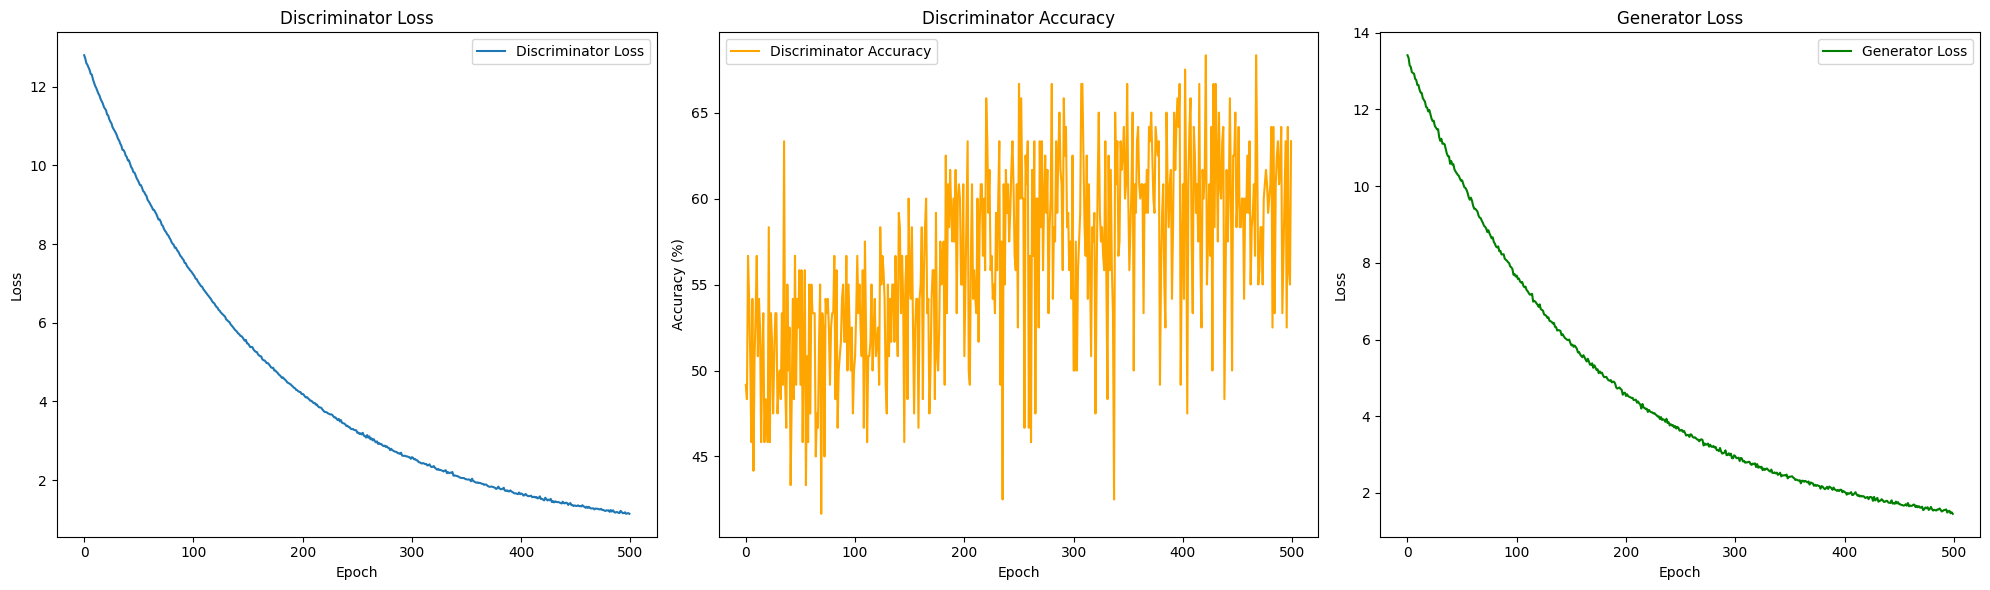

In [7]:
#--------------------------------------------------------------------------------
# Module 7: Visualize the Loss and Accuracy
#--------------------------------------------------------------------------------

import matplotlib.pyplot as plt

# Create a new figure for the plots
plt.figure(figsize=(20, 6))

# Plotting Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Discriminator Accuracy
plt.subplot(1, 3, 2)
plt.plot(d_accuracies, label='Discriminator Accuracy', color='orange')
plt.title('Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plotting Generator Loss
plt.subplot(1, 3, 3)
plt.plot(g_losses, label='Generator Loss', color='green')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
#--------------------------------------------------------------------------------
# Module 8: Synthetic Data Generation and Inverse Transformation
# 1. This module defines a function to generate synthetic data samples using a GAN.
# 2. It then inverses the one-hot encoding and normalization transformations to obtain
# data in a format similar to the original input data. The resulting synthetic data 
# is then printed for inspection. 
#--------------------------------------------------------------------------------

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
#Assuming you have your original dataframe named 'data' loaded from CSV
data = pd.read_csv("Cleaned Data/RT.IRS_Clean_v2.csv")
# Recreate the scaler object
numerical_columns = data_encoded.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
data_encoded[numerical_columns] = scaler.fit_transform(data[numerical_columns])# oklart varför men det måste vara data_encoded = data för att alla kolumner ska dyka upp i output filen

# Identify original categorical columns before one-hot encoding
original_categorical_columns = data_encoded.select_dtypes(include=['object']).columns

def generate_and_inverse_transform(generator, num_samples=20):
    # 1. Generate synthetic data using the GAN
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    generated_samples = generator.predict(noise)
    #print(generated_samples)
    #print(data_encoded.columns)

    # Convert generated samples to DataFrame
    generated_df = pd.DataFrame(generated_samples, columns=data_encoded.columns)
    print(original_categorical_columns)
    # 2. Inverse one-hot encoding to get original categorical columns
    for original_col in original_categorical_columns:
        one_hot_cols = [col for col in generated_df.columns if col.startswith(original_col + "_")]
        if one_hot_cols:
            generated_df[original_col] = generated_df[one_hot_cols].idxmax(axis=1).str.replace(original_col + "_", "")
            generated_df.drop(one_hot_cols, axis=1, inplace=True)

    # 3. Inverse normalization to get the original values of numerical columns
    generated_df[numerical_columns] = scaler.inverse_transform(generated_df[numerical_columns])

    # Ensure all columns from the original data are present in generated_df
    for col in data.columns:
        if col not in generated_df.columns:
            generated_df[col] = np.nan
    
    # Ensure the columns are in the same order as the original data
    generated_df = generated_df[data.columns]
    
    return generated_df


# Call the function and print synthetic data
synthetic_data = generate_and_inverse_transform(generator)


1/1 [==============================] - 0s 31ms/step
Index([], dtype='object')


In [9]:
#--------------------------------------------------------------------------------
# Module 9: Generate Synthesized Data and Save to CSV
#--------------------------------------------------------------------------------
output_file_path = "Synthesized data/RT.IRS_Clean_v1.csv"

def save_synthesized_data(generator, num_samples=1000, output_file_path="Synthesized Data/synthesized_data.csv"):
    # Generate synthetic data
    synthetic_data = generate_and_inverse_transform(generator, num_samples=num_samples)
    
    # Save the synthesized data to a CSV file
    synthetic_data.to_csv(output_file_path, index=False)
    print(synthetic_data.columns)
    
    print(f"Synthesized data generated and saved to {output_file_path}")

# Call the function to generate and save the synthetic data
save_synthesized_data(generator)


32/32 [==============================] - 0s 11ms/step
Index([], dtype='object')
Index(['Event', 'Execution Timestamp', 'Dissemination Time', 'Cleared',
       'Collateralization', 'End-User Exception', 'Bespoke',
       'Block/Off facility', 'Execution Venue', 'UPI', 'Product',
       'Contract Type', 'Effective Date', 'Maturity Date', 'Upfront Payment',
       'Upfront Payment Currency', 'Upfront Payment Date',
       'Settlement Currency', 'Leg 1 Type', 'Leg 1 Fixed Rate',
       'Leg 1 Floating Index', 'Leg 1 Designated Maturity', 'Leg 1 Spread',
       'Leg 1 Day Count Convention', 'Leg 1 Notional',
       'Leg 1 Notional Currency', 'Leg 1 Payment Frequency',
       'Leg1 Reset Frequency', 'Leg 2 Type', 'Leg 2 Fixed Rate',
       'Leg 2 Floating Index', 'Leg 2 Designated Maturity', 'Leg 2 Spread',
       'Leg 2 Day Count Convention', 'Leg 2 Notional',
       'Leg 2 Notional Currency', 'Leg 2 Payment Frequency',
       'Leg 2 Reset Frequency', 'Embedded Option', 'Option Strike Price